In [4]:
import os
import pickle
import yaml
import functools

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, feature

import ase
from ase.visualize.plot import plot_atoms

import ml_collections
from clu import checkpoint

from molnet import utils, train_state, train
from molnet.data import input_pipeline_online
from molnet.models import create_model
from configs import root_dirs
from analyses import make_predictions

from typing import Tuple

INDEX_TO_ELEM = {
    0: 'H',
    1: 'C',
    2: 'N',
    3: 'O',
    4: 'F',
}

In [5]:
def load_from_workdir(
    workdir: str,
    return_attention: bool
):
    # Load the model config
    with open(os.path.join(workdir, "config.yaml"), "rt") as f:
        config = yaml.unsafe_load(f)
    config = ml_collections.ConfigDict(config)
    config.root_dir = root_dirs.get_root_dir("afms_rebias")
    config.model.return_attention_maps = return_attention

    print(config)

    # Create the model
    model = create_model(config.model)

    checkpoint_dir = os.path.join(workdir, "checkpoints")
    ckpt = checkpoint.Checkpoint(checkpoint_dir)

    apply_fn = model.apply
    tx = utils.create_optimizer(config)
    restored_state = ckpt.restore(state=None)['state']

    # Load the model state
    state = train_state.EvaluationState.create(
        apply_fn=apply_fn,
        params=restored_state['params'],
        batch_stats=restored_state['batch_stats'],
        tx=tx,
    )
    state = jax.tree_util.tree_map(jnp.asarray, state)

    return state, config


In [6]:
workdir = "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-halogen-adam-3e-4-z10-gx5/"

state, config = load_from_workdir(
    workdir=workdir,
    return_attention=True
)

batch_size: 24
cutout_probs:
- 0.5
- 0.3
- 0.1
- 0.05
- 0.05
dataset: afm_192_light_bromine
debug: false
eval_every_steps: 2000
gaussian_factor: 5.0
interpolate_input_z: null
learning_rate: 0.0003
learning_rate_schedule: constant
learning_rate_schedule_kwargs:
  decay_steps: 50000
  init_value: 0.0003
  peak_value: 0.0006
  warmup_steps: 2000
log_every_steps: 100
loss_fn: mse
max_atoms: 54
max_shift_per_slice: 0.02
model:
  attention_activation: sigmoid
  attention_channels:
  - 32
  - 32
  - 32
  - 32
  - 32
  conv_activation: relu
  decoder_channels:
  - 256
  - 128
  - 64
  - 32
  - 16
  decoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  dtype: bfloat16
  encoder_channels:
  - 16
  - 32
  - 64
  - 128
  - 256
  encoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  model_name: Attention-UNet
  output_activ

2025-01-16 12:26:53.985597: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
def get_image_with_fixed_resolution(data, resolution=0.125):
    x, lx, ly = data["data"], data["lengthX"], data["lengthY"]

    new_size = (int(lx / resolution), int(ly / resolution))
    print(f"New size: {new_size}")

    # resize image
    x = transform.resize(x, new_size, mode='reflect', anti_aliasing=True)
    
    return x

def normalize_image(x):
    xmean = np.mean(x, axis=(0, 1), keepdims=True)
    xstd = np.std(x, axis=(0, 1), keepdims=True)
    x = (x - xmean) / xstd
    return x

def pad_image_xy(x, target_shape):
    x = np.pad(
        x,
        ((0, target_shape[0] - x.shape[0]), (0, target_shape[1] - x.shape[1]), (0, 0)),
        mode="symmetric" # [reflect, symmetric, edge, wrap]
    )
    return x

def fix_resolution_and_pad_to_smallest_multiple_of_32(data):
    x = get_image_with_fixed_resolution(data)
    x = pad_image_xy(
        x,
        (
            (x.shape[0] + 31) // 32 * 32,
            (x.shape[1] + 31) // 32 * 32
        )
    )
    x = normalize_image(x)
    return x

In [7]:
root_dir = '/l/exp_data/'
exclude_dirs = []
datasets = [
    os.path.join(root_dir, folder) 
    for folder in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, folder))
]

print(datasets)
i = 3
print(os.listdir(datasets[i]))

['/l/exp_data/Br-Cl-I-Benzene', '/l/exp_data/Xylotetraose', '/l/exp_data/22Bipyrimidine', '/l/exp_data/BCB', '/l/exp_data/Water', '/l/exp_data/PTCDA', '/l/exp_data/DBBA', '/l/exp_data/1S-Camphor', '/l/exp_data/Me-PTCDI', '/l/exp_data/Xe-cluster', '/l/exp_data/Nitrophenyls']
['BCB_Xe.npz', 'BCB_CO.npz']


dataset: /l/exp_data/BCB
files: ['/l/exp_data/BCB/BCB_Xe.npz', '/l/exp_data/BCB/BCB_CO.npz']
file: /l/exp_data/BCB/BCB_CO.npz
original shape: (512, 512, 13), lx: 13.5, ly: 13.5
New size: (108, 108)
shape w/ fixed res: (128, 128, 13)


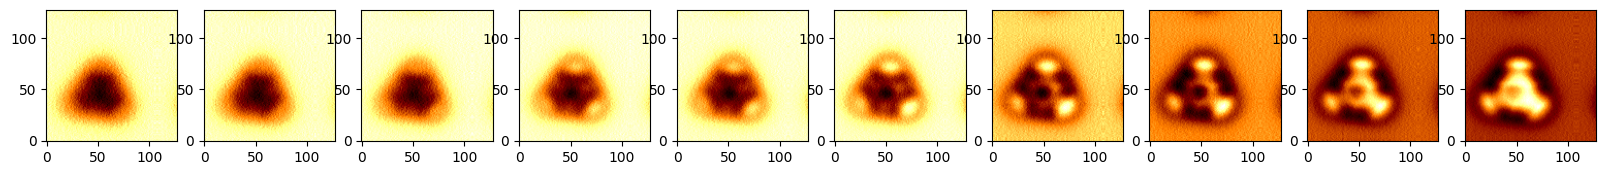

In [8]:
ds = datasets[3]
files = [
    os.path.join(ds, file)
    for file in os.listdir(ds)
    if file.endswith('.npz')
]
f = files[1]

print(f"dataset: {ds}")
print(f"files: {files}")
print(f"file: {f}")

data = np.load(f, allow_pickle=True)

orig_x, lx, ly = data['data'], data["lengthX"], data["lengthY"]
print(f"original shape: {orig_x.shape}, lx: {lx}, ly: {ly}")
x = fix_resolution_and_pad_to_smallest_multiple_of_32(data)
print(f"shape w/ fixed res: {x.shape}")

x = jnp.array(x)
x = x[None, ..., :10, None]

fig = plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    ax.imshow(x[0, ..., i, 0].T, cmap='afmhot', origin='lower')
plt.show()

# Make predictions
preds, attention = state.apply_fn(
    {'params': state.params, 'batch_stats': state.batch_stats},
    x,
    training=False,
)

### Plotting

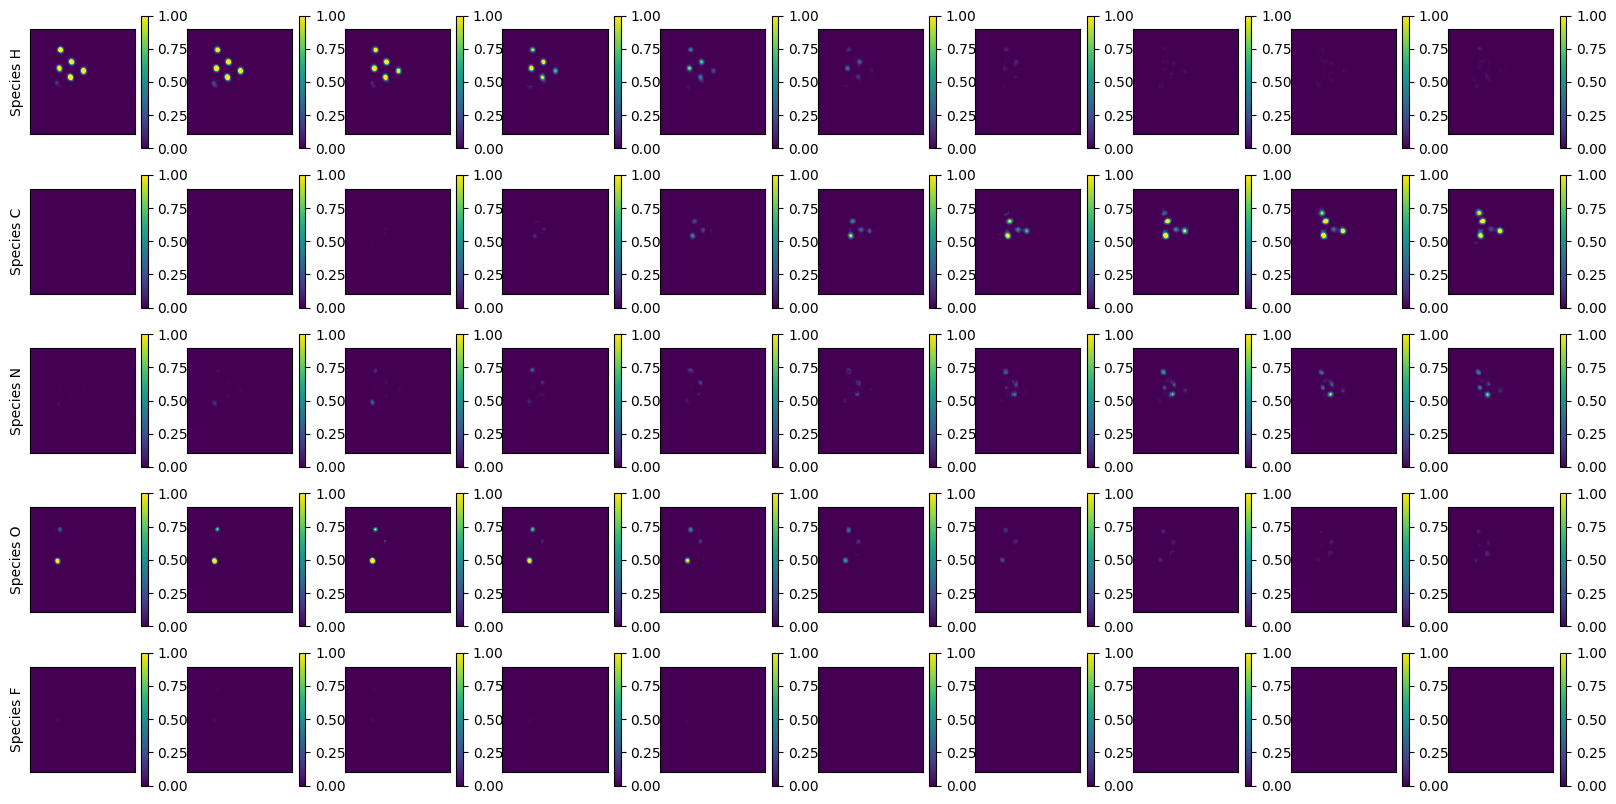

In [10]:
n_images = preds.shape[-2]
n_species = 5

fig, axs = plt.subplots(n_species, n_images, figsize=(n_images * 2, n_species * 2))

for i in range(n_images):
    for j in range(n_species):
        ax = axs[j, i]
        im = ax.imshow(preds[0, ..., i, j], cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(im, ax=ax)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

        if i == 0:
            ax.set_ylabel(f"Species {INDEX_TO_ELEM[j]}")

#plt.tight_layout()
plt.show()

In [11]:
peaks = feature.peak_local_max(
    preds[0],
    min_distance=5,
    exclude_border=0,
    threshold_rel=0.3
)

scan_dim = [
    px * im for px, im in zip((0.125, 0.125, 0.1), (preds.shape[2], preds.shape[1], preds.shape[3]))
]
print(scan_dim)
xyz_from_peaks = peaks[:, [1, 0, 2]] * (0.125, 0.125, 0.1)
elem_from_peaks = peaks[:, 3]

mol = ase.Atoms(
    positions=xyz_from_peaks,
    symbols=[INDEX_TO_ELEM[elem] for elem in elem_from_peaks],
    cell=scan_dim
)


[16.0, 16.0, 1.0]


<Axes: >

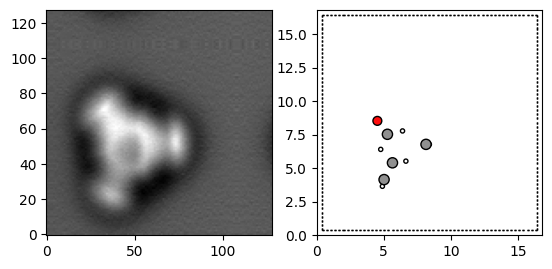

In [12]:
ax = plt.subplot(121)
ax.imshow(x[0, ..., -1, 0], cmap='gray', origin='lower')

ax = plt.subplot(122)
plot_atoms(mol, ax, radii=0.5)

## Simulation data

In [7]:
datasets = input_pipeline_online.get_datasets(
    config
)
valset = datasets['val']

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131


In [10]:
# Get one batch
batch = next(valset)
x = batch['images']

# Make predictions
preds, attention = state.apply_fn(
    {'params': state.params, 'batch_stats': state.batch_stats},
    x,
    training=False,
)

In [13]:
print(x.shape)
print(preds.shape)
print(len(attention))

(24, 128, 128, 10, 1)
(24, 128, 128, 10, 7)
5


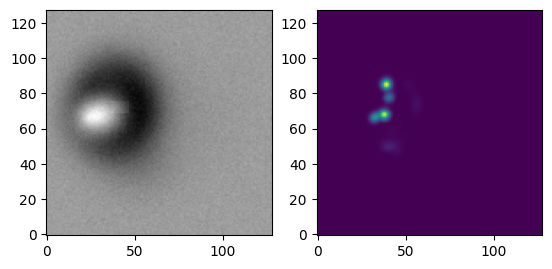

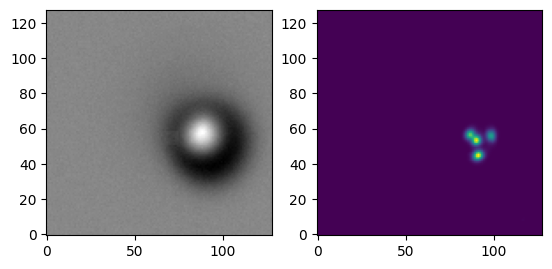

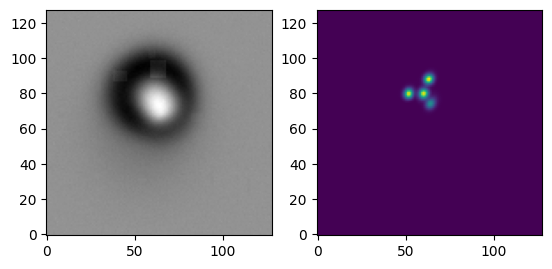

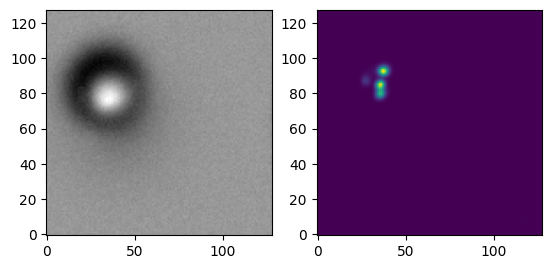

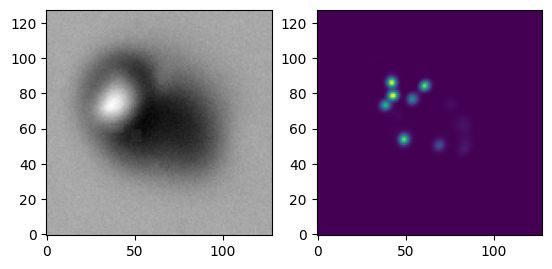

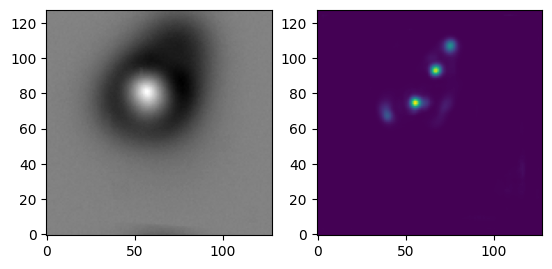

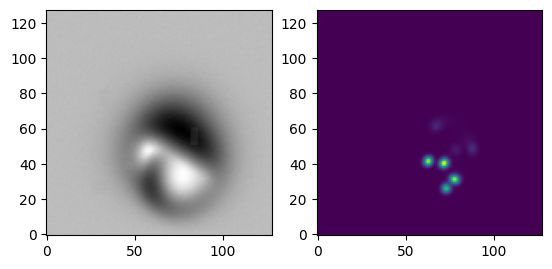

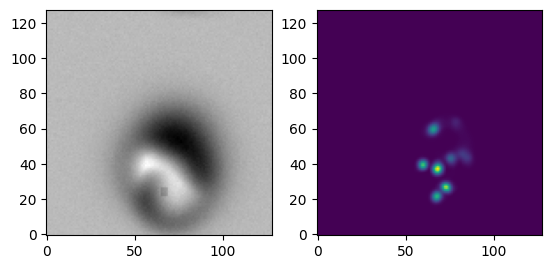

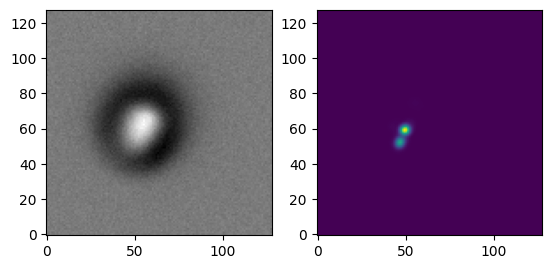

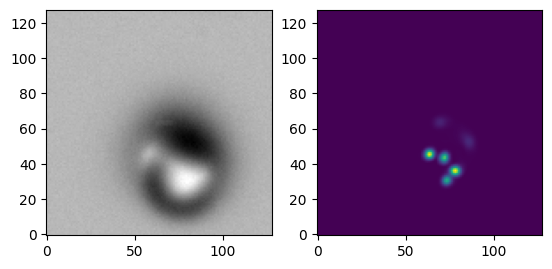

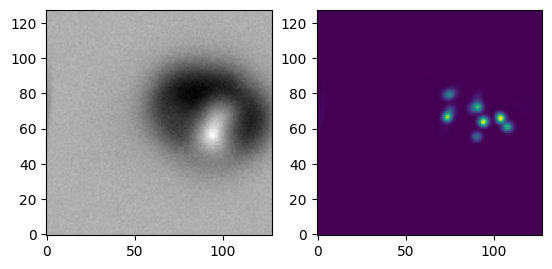

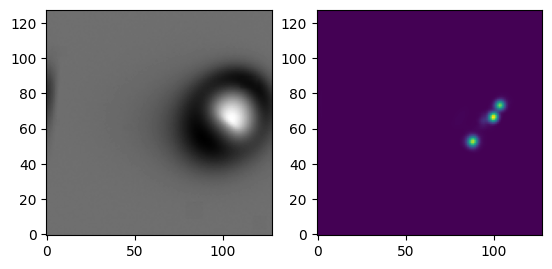

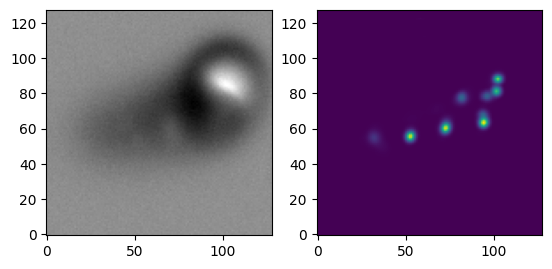

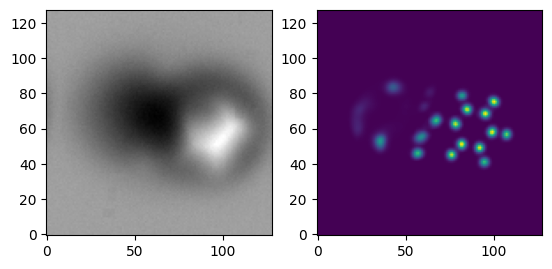

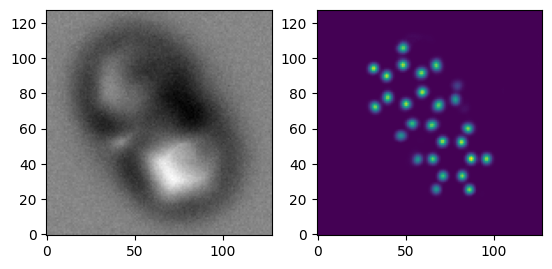

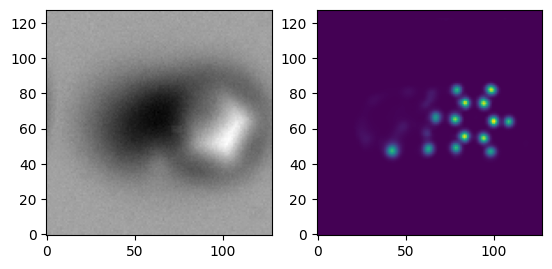

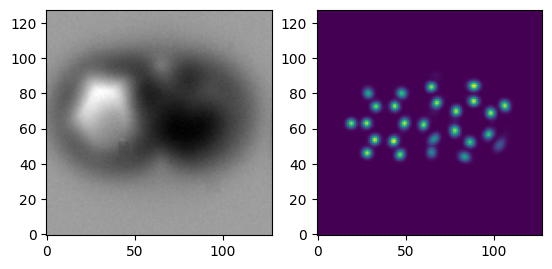

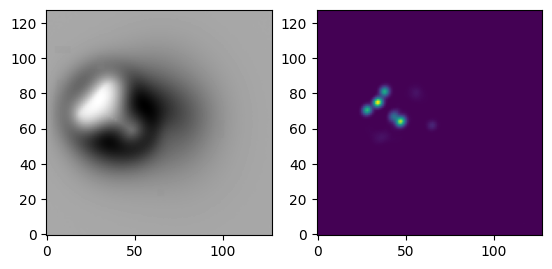

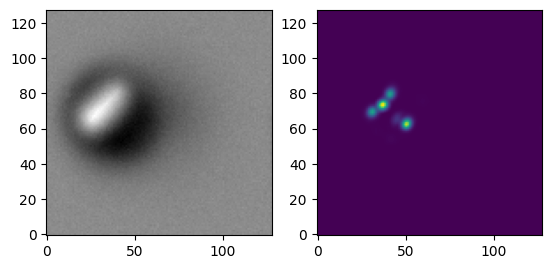

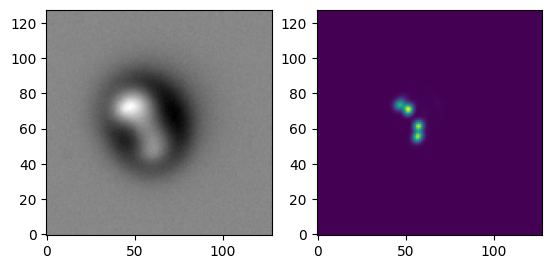

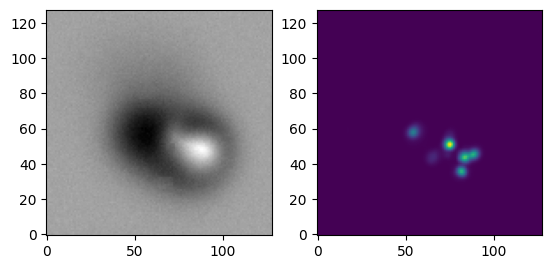

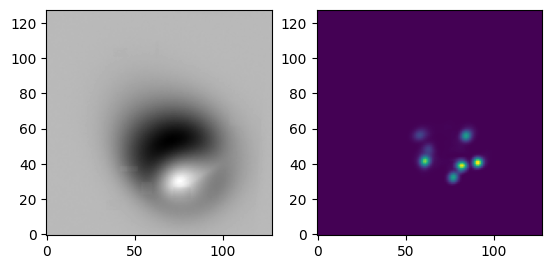

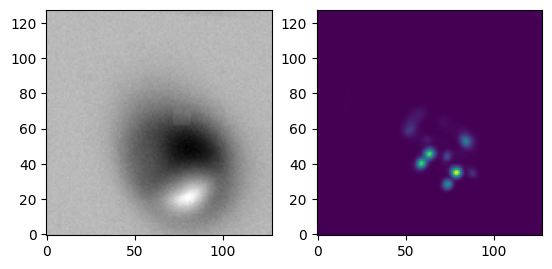

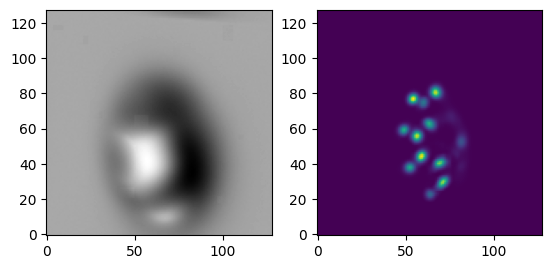

In [14]:
for i in range(preds.shape[0]):
    xi = x[i].mean(axis=(-2,-1))
    pi = preds[i].mean(axis=(-2,-1))

    ax = plt.subplot(121)
    ax.imshow(xi, cmap='gray', origin='lower')

    ax = plt.subplot(122)
    ax.imshow(pi, cmap='viridis', origin='lower')

    plt.show()